In [13]:
elastic_rods_dir = '../../../../elastic_rods/python/'
weaving_dir = '../../../'
import os
import os.path as osp
import sys; sys.path.append(elastic_rods_dir); sys.path.append(weaving_dir)
import numpy as np, elastic_rods, linkage_vis
import numpy.linalg as la
from bending_validation import suppress_stdout as so
import matplotlib.pyplot as plt
from elastic_rods import EnergyType, InterleavingType

# weaving
import analysis_helper, ribbon_linkage_helper, mesh_vis, linkage_utils, compute_curve_from_curvature, pipeline_helper, importlib
importlib.reload(analysis_helper)
importlib.reload(ribbon_linkage_helper)
importlib.reload(mesh_vis)
importlib.reload(linkage_utils)
importlib.reload(compute_curve_from_curvature)
importlib.reload(pipeline_helper)
from analysis_helper import (compare_turning_angle,
                            is_on_sphere, 
                            get_distance_to_center_scalar_field, 
                            plot_curvatures, 
                            get_curvature_scalar_field,
                            construct_elastic_rod_loop_from_rod_segments, 
                            concatenate_rod_properties_from_rod_segments, 
                            compute_min_distance_rigid_transformation)
from ribbon_linkage_helper import (update_rest_curvature, 
                                   set_ribbon_linkage,
                                   export_linkage_geometry_to_obj,
                                   write_linkage_ribbon_output_florin)

from compute_curve_from_curvature import (match_geo_curvature_and_edge_len, get_all_curve_pattern)
from linkage_utils import order_segments_by_ribbons, get_turning_angle_and_length_from_ordered_rods

from pipeline_helper import (initialize_linkage, get_normal_deviation, set_joint_vector_field, stage_1_optimization, initialize_stage_2_optimizer, stage_2_optimization, InputOrganizer, write_all_output, set_surface_view_options, get_structure_analysis_view, contact_optimization, get_double_side_view, show_selected_joints, highlight_rod_and_joint)
import vis.fields
import matplotlib.cm as cm
import time

In [14]:
edge_length = 15
cam_params = ((2.0787438565755934, 4.110669876049863, -1.9445352012461516),
 (-0.3012591112717844, -0.2789859717380453, -0.9118167444443614),
 (0.0, 0.0, 0.0))

### Triaxial Singularity Patches

In [15]:
polygon_size = 6

In [23]:
def get_radius(length, num_sides):
    theta = np.pi * 2 / num_sides
    beta = (np.pi - theta) / 2
    radius = length * np.sin(beta) / np.sin(theta)
    return radius
def get_patch(polygon_size = 5):
    vertices = []
    edges = []
    radius = get_radius(1, polygon_size)
    for i in range(polygon_size):
        theta = 2 * np.pi / polygon_size * i
        point = np.array([radius * np.sin(theta), radius * np.cos(theta), 0])
        vertices.append(point)
        edges.append([i, (i + 1)%polygon_size])
    for i in range(polygon_size):
        theta = 2 * np.pi / polygon_size * i + np.pi / polygon_size
        point = np.array([2 * radius * np.sin(theta), 2 * radius * np.cos(theta), 0])
        vertices.append(point)
        edges.append([i + polygon_size, i])
        edges.append([i + polygon_size, (i+1)%polygon_size])
    for i in range(polygon_size):
        theta_1 = 2 * np.pi / polygon_size * i + 0.5 *  np.pi / polygon_size
        theta_2 = 2 * np.pi / polygon_size * i + 1.5 * np.pi / polygon_size
        point = np.array([3 * radius * np.sin(theta_1), 3 * radius * np.cos(theta_1), 0])
        vertices.append(point)
        point = np.array([3 * radius * np.sin(theta_2), 3 * radius * np.cos(theta_2), 0])
        vertices.append(point)
        edges.append([i * 2 + polygon_size * 2, i + polygon_size])
        edges.append([i * 2 + polygon_size * 2 + 1, i + polygon_size])
        edges.append([i * 2 + polygon_size * 2, i * 2 + polygon_size * 2 + 1])

    for i in range(polygon_size):
        theta = 2 * np.pi / polygon_size * i
        point = np.array([4 * radius * np.sin(theta), 4 * radius * np.cos(theta), 0])
        vertices.append(point)
        if i == 0:
            edges.append([i + polygon_size * 4, polygon_size * 2 - 1 + polygon_size * 2])
            edges.append([i + polygon_size * 4, i * 2 + polygon_size * 2])
        else:
            edges.append([i + polygon_size * 4, i * 2 - 1 + polygon_size * 2])
            edges.append([i + polygon_size * 4, i * 2 + polygon_size * 2])

    for i in range(polygon_size):
        theta_1 = 2 * np.pi / polygon_size * i + 0.5 *  np.pi / polygon_size
        theta_2 = 2 * np.pi / polygon_size * i - 0.5 * np.pi / polygon_size
        point = np.array([5 * radius * np.sin(theta_1), 5 * radius * np.cos(theta_1), 0])
        vertices.append(point)
        point = np.array([5 * radius * np.sin(theta_2), 5 * radius * np.cos(theta_2), 0])
        vertices.append(point)
        edges.append([i * 2 + polygon_size * 5, i + polygon_size * 4])
        edges.append([i * 2 + polygon_size * 5 + 1, i + polygon_size * 4])
        
        edges.append([i * 2 + polygon_size * 5, i * 2 + polygon_size * 2])
        if i == 0:
            edges.append([i * 2 + polygon_size * 5 + 1, polygon_size * 4-1])
        else:
            edges.append([i * 2 + polygon_size * 5 + 1, i * 2 + polygon_size * 2 - 1])

    return vertices, edges

def get_layers():
    p1_vx, p1_edge = get_patch(polygon_size)
    p2_vx, p2_edge = get_patch(polygon_size)
    p3_vx, p3_edge = get_patch(polygon_size)
    p1_vx = [vx + [0, 0, 3] for vx in p1_vx]
    p2_vx = [vx + [0, 0, 6] for vx in p2_vx]
    p3_vx = [vx + [0, 0, 9] for vx in p3_vx]
    p2_edge = [[vx + len(p1_vx) for vx in edge] for edge in p2_edge]
    p3_edge = [[vx + len(p1_vx) + len(p2_vx) for vx in edge] for edge in p3_edge]
    total_vx = p1_vx + p2_vx + p3_vx
    total_edge = p1_edge + p2_edge + p3_edge + [[len(p1_vx) - 1 - i, len(p1_vx) + len(p2_vx) - 1 - i] for i in range(polygon_size * 2)] + [[len(total_vx) - 1 - i, len(p1_vx) + len(p2_vx) - 1 - i] for i in range(polygon_size * 2)]


    basket_path = 'basket'
    if not os.path.exists(basket_path):
        os.makedirs(basket_path)

    with open ('{}/{}_gon.obj'.format(basket_path, polygon_size), 'w') as f:
        for point in total_vx:
            f.write('v {} {} {}\n'.format(point[0], point[1], point[2]))
        for edge in total_edge:
            f.write('l {} {}\n'.format(edge[0]+1, edge[1]+1))
get_layers()

In [24]:
rod_length = 1
width = rod_length / 15 * 5
thickness = width / 5 * 0.35
print(width, thickness)
io = InputOrganizer('singularity_{}'.format(polygon_size), thickness, width, weaving_dir)

0.3333333333333333 0.02333333333333333


In [27]:
import py_newton_optimizer
OPTS = py_newton_optimizer.NewtonOptimizerOptions()
OPTS.gradTol = 1e-6
OPTS.verbose = 1;
OPTS.beta = 1e-8
OPTS.niter = 200
OPTS.verboseNonPosDef = False
rw = 1
sw = 10
drw = 0.01
dsw = 0.01

In [38]:
with so(): curved_linkage = initialize_linkage(surface_path = None, useCenterline = True, model_path = 'basket/{}_gon.obj'.format(polygon_size), cross_section = io.RIBBON_CS, subdivision_res = io.SUBDIVISION_RESOLUTION, use_constant_width=True, interleaving_type=elastic_rods.InterleavingType.weaving)
curved_linkage.set_design_parameter_config(use_restLen = True, use_restKappa = True)
curved_save_tgt_joint_pos = curved_linkage.jointPositions();
curved_linkage_view = linkage_vis.LinkageViewer(curved_linkage)
curved_linkage_view.show()

Renderer(camera=PerspectiveCamera(children=(PointLight(color='#999999', position=(0.0, 0.0, 5.0), quaternion=(…

In [39]:
curved_linkage.numSegments()

240

In [40]:
# psrl = np.ones(curved_linkage.numSegments())

Triaxial Geometric Singularity - Positive Gaussian

In [41]:
# psrl[:6] *= 1.4
# psrl[6:18] *= 1.35
# psrl[18:36] *= 1.3
# psrl[36:48] *= 1.2
# psrl[48:72] *= 1.15
# psrl[72:] *= 0.9

Triaxial Geometric Singularity - Negative Gaussian

In [42]:
# psrl[:6] *= 1/1.4
# psrl[6:18] *= 1/1.35
# psrl[18:36] *= 1/1.3
# psrl[36:48] *= 1/1.2
# psrl[48:72] *= 1/1.15
# psrl[72:] *= 1/0.9
# psrl *= 1.1

In [43]:
bottomColor =[79/255., 158/255., 246/255.]
topColor =[0.5, 0.5, 0.5]
heights = curved_linkage.visualizationGeometryHeightColors()
colors = np.take(np.array([bottomColor, topColor]), heights < heights.mean(), axis=0)

In [44]:
# curved_linkage.setPerSegmentRestLength(psrl)

In [45]:
E0 = curved_linkage.designParameterSolve_energy()
l0 = curved_linkage.totalRestLength()
iterateData, dpo = stage_1_optimization(curved_linkage, drw, dsw, curved_linkage_view, E0 = E0, l0 = l0, niter = 400)

In [46]:
def eqm_callback(prob, i):
    curved_linkage_view.update(scalarField=colors)

In [47]:
driver=curved_linkage.centralJoint()
jdo = curved_linkage.dofOffsetForJoint(driver)
fixedVars = list(range(jdo, jdo + 6)) # fix rigid motion for a single joint
with so(): elastic_rods.compute_equilibrium(curved_linkage, fixedVars=fixedVars, callback = eqm_callback, options = OPTS)

In [ ]:
curved_linkage_view.update(scalarField=colors)

In [ ]:
# save_path = os.getcwd()
# write_all_output(curved_linkage, io.SUBDIVISION_RESOLUTION, io.MODEL_NAME + '_geometric_irregularity_positive', io.RIBBON_NAME, False, 1, min(io.RIBBON_CS), target_width = 5, flip_angles = False, width = max(io.RIBBON_CS), use_surface = False)
# os.chdir(save_path)

## Contact Optimization

../../../../elastic_rods/python/structural_analysis.py:213: RuntimeWarning: invalid value encountered in true_divide
  coefficientOfFriction = cfm[:, 1] / (-separationForce)
/Users/yren/Library/Python/3.7/lib/python/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/yren/Library/Python/3.7/lib/python/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


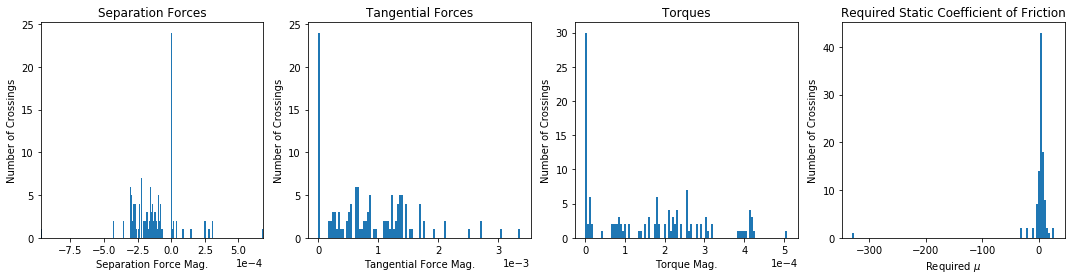

In [48]:
structure_view = get_structure_analysis_view(curved_linkage)
structure_view.show()

In [49]:
def get_opposite_joint_type(curr_type):
    if curr_type == curved_linkage.joint(0).Type.A_OVER_B:
        return curved_linkage.joint(0).Type.B_OVER_A
    return curved_linkage.joint(0).Type.A_OVER_B
import structural_analysis

In [50]:
cfm = structural_analysis.weavingCrossingForceMagnitudes(curved_linkage, True)
if np.sum(cfm[:, 0]>0) > 0:
    print("Flipping crossing: ", np.argsort(cfm[:, 0] > 0)[-1 * np.sum(cfm[:, 0] > 0):])
    for i in np.argsort(cfm[:, 0] > 0)[-1 * np.sum(cfm[:, 0] > 0):]:
        curved_linkage.joint(i).type = get_opposite_joint_type(curved_linkage.joint(i).type)
    elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS)
    curved_linkage_view.update()

Flipping crossing:  [ 57  26  80  78  77  76  75  73  45  70  68  66  65  58 110  62]
0	0.148469	7.50657	7.50657	1	1
1	0.0668914	11.7487	11.7487	1	1
2	0.0410217	0.4251	0.4251	1	1
3	0.0379991	0.246838	0.246838	1	1
4	0.0350948	0.178476	0.178476	1	1
5	0.0322423	0.13343	0.13343	1	1
6	0.0295572	0.104255	0.104255	1	1
7	0.0272255	0.0870078	0.0870078	1	1
8	0.025396	0.0698361	0.0698361	1	1
9	0.0240972	0.0507566	0.0507566	1	1
10	0.0232331	0.0333999	0.0333999	1	1
11	0.022681	0.0217286	0.0217286	1	1
12	0.0223543	0.0143931	0.0143931	1	1
13	0.0221734	0.0092425	0.0092425	1	1
14	0.0220791	0.00631584	0.00631584	1	1
15	0.0220334	0.00367056	0.00367056	1	1
16	0.0220102	0.0022373	0.0022373	1	1
17	0.0219957	0.00178121	0.00178121	1	1
18	0.0219857	0.00171829	0.00171829	1	1
19	0.0219792	0.00173357	0.00173357	1	1
20	0.0219755	0.00127924	0.00127924	1	1
21	0.0219736	0.000828674	0.000828674	1	1
22	0.0219724	0.000611133	0.000611133	1	1
23	0.0219716	0.000367703	0.000367703	1	1
24	0.0219708	0.000330938	0.000330938	1	

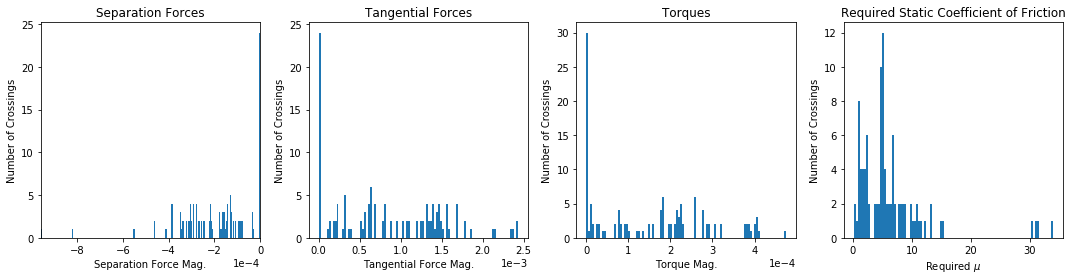

In [51]:
second_structure_view = get_structure_analysis_view(curved_linkage)
second_structure_view.show()

In [31]:
cfm = structural_analysis.weavingCrossingForceMagnitudes(curved_linkage, True)
if np.sum(cfm[:, 0]>0) > 0:
    print("Flipping crossing: ", np.argsort(cfm[:, 0] > 0)[-1 * np.sum(cfm[:, 0] > 0):])
    for i in np.argsort(cfm[:, 0] > 0)[-1 * np.sum(cfm[:, 0] > 0):]:
        curved_linkage.joint(i).type = get_opposite_joint_type(curved_linkage.joint(i).type)
    elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS)
    curved_linkage_view.update()

Flipping crossing:  [40]
0	0.000342827	0.219982	0.219982	0.0625	1
1	0.000317247	0.300223	0.300223	1	1
2	0.000269646	1.78549	1.78549	1	1
3	0.000117913	0.35982	0.35982	1	1
4	9.80277e-05	0.0214922	0.0214922	1	1
5	9.27493e-05	0.00782052	0.00782052	1	1
6	8.81046e-05	0.00614681	0.00614681	1	1
7	8.38511e-05	0.00491468	0.00491468	1	1
8	8.011e-05	0.00382015	0.00382015	1	1
9	7.69553e-05	0.00317724	0.00317724	1	1
10	7.44059e-05	0.00277645	0.00277645	1	1
11	7.24602e-05	0.00221079	0.00221079	1	1
12	7.10864e-05	0.00157607	0.00157607	1	1
13	7.01805e-05	0.00100822	0.00100822	1	1
14	6.95901e-05	0.000573356	0.000573356	1	1
15	6.91839e-05	0.000342224	0.000342224	1	1
16	6.8886e-05	0.000242454	0.000242454	1	1
17	6.8662e-05	0.000179775	0.000179775	1	1
18	6.84977e-05	0.000131647	0.000131647	1	1
19	6.83819e-05	0.000130265	0.000130265	1	1
20	6.83024e-05	0.000127273	0.000127273	1	1
21	6.82514e-05	0.000169862	0.000169862	1	1
22	6.82218e-05	0.000210085	0.000210085	1	1
23	6.82059e-05	0.000222793	0.000222793	1	1
24

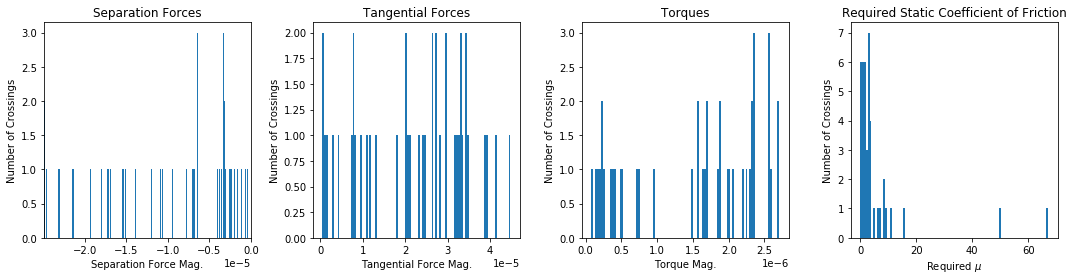

In [32]:
third_structure_view = get_structure_analysis_view(curved_linkage)
third_structure_view.show()

In [38]:
cfm = structural_analysis.weavingCrossingForceMagnitudes(curved_linkage, True)
if np.sum(cfm[:, 0]>0) > 0:
    print("Flipping crossing: ", np.argsort(cfm[:, 0] > 0)[-1 * np.sum(cfm[:, 0] > 0):])
    for i in np.argsort(cfm[:, 0] > 0)[-1 * np.sum(cfm[:, 0] > 0):]:
        curved_linkage.joint(i).type = get_opposite_joint_type(curved_linkage.joint(i).type)
    elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS)
    curved_linkage_view.update()

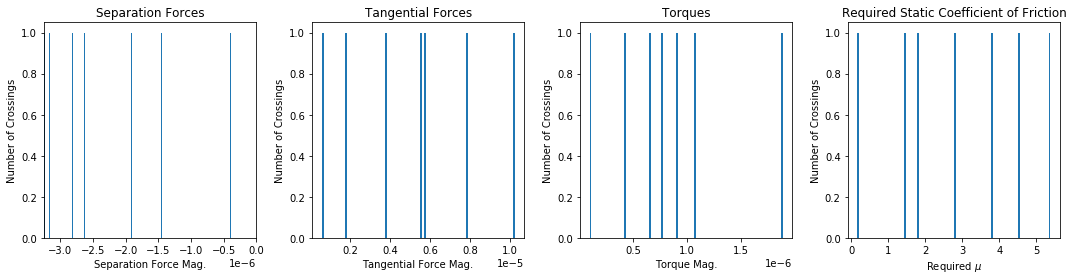

In [39]:
fourth_structure_view = get_structure_analysis_view(curved_linkage)
fourth_structure_view.show()

Min Width  0.3333333333333333
Scale:  15.0
num seg per rod 7
num seg per rod 7
num seg per rod 7
num seg per rod 7
num seg per rod 7
num seg per rod 7
num seg per rod 66
num seg per rod 66
num seg per rod 12
num seg per rod 7
num seg per rod 7
num seg per rod 7
num seg per rod 7
num seg per rod 7
num seg per rod 7
num seg per rod 12


AttributeError: 'elastic_rods.RodLinkage' object has no attribute 'get_squared_distance_to_target_surface'

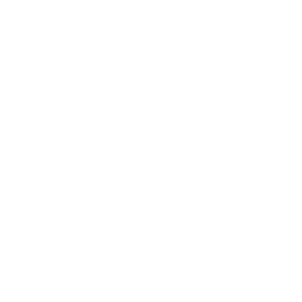

In [52]:
save_path = os.getcwd()
write_all_output(curved_linkage, io.SUBDIVISION_RESOLUTION, io.MODEL_NAME + '_contact_opt', io.RIBBON_NAME + '_contact_opt', False, 100, min(io.RIBBON_CS), target_width = 5, flip_angles = False)
os.chdir(save_path)

In [53]:
export_linkage_geometry_to_obj(curved_linkage, '{}_contact_opt.obj'.format(io.MODEL_NAME))

### Biaxial

In [ ]:
grid_size = 4

In [ ]:
def generate_biaxial_grid(grid_size):
    unit_width = 1
    vertices = []
    edges = []

    for i in range(grid_size):
        for j in range(grid_size):
            vertices.append([i, j, 0])
    
    for i in range(grid_size):
        vertices.append([-1, i, 0])
        vertices.append([grid_size, i, 0])
    for i in range(grid_size):
        vertices.append([i, -1, 0])
        vertices.append([i, grid_size, 0])

    for i in range(grid_size):
        for j in range(grid_size - 1):
            edges.append([i * grid_size + j, i * grid_size + j + 1])
            
    for i in range(grid_size):
        for j in range(grid_size - 1):
            edges.append([i + grid_size * j, i  + grid_size * (j + 1)])
    
    for i in range(grid_size):
        edges.append([grid_size ** 2 + i * 2, i])
        edges.append([grid_size ** 2 + i * 2 + 1, grid_size ** 2 - grid_size + i])
        
        edges.append([grid_size ** 2 + grid_size * 2 + i * 2, i * (grid_size)])
        edges.append([grid_size ** 2 + grid_size * 2 + i * 2 + 1, i * (grid_size) + grid_size - 1])
        

    print(edges)
    biaxial_path = 'biaxial'
    if not os.path.exists(biaxial_path):
        os.makedirs(biaxial_path)

    with open ('{}/{}_grid.obj'.format(biaxial_path, grid_size), 'w') as f:
        for point in vertices:
            f.write('v {} {} {}\n'.format(point[0], point[1], point[2]))
        for edge in edges:
            f.write('l {} {}\n'.format(edge[0]+1, edge[1]+1))


In [ ]:
generate_biaxial_grid(grid_size)

In [ ]:
rod_length = 1
width = rod_length / 20 * 5
# thickness = width / 1 * 0.35
thickness = width 
# thickness = 0.017499999999999998
print(width, thickness)
io = InputOrganizer('biaxial_{}'.format(grid_size), thickness, width, weaving_dir)

In [ ]:
OPTS = elastic_rods.NewtonOptimizerOptions()
OPTS.gradTol = 1e-6
OPTS.verbose = 1;
OPTS.beta = 1e-8
OPTS.niter = 10000
OPTS.verboseNonPosDef = False
rw = 0.01
sw = 0.01

In [ ]:
with so(): curved_linkage = initialize_linkage(surface_path = None, useCenterline = True, model_path = 'biaxial/{}_grid.obj'.format(grid_size), cross_section = io.RIBBON_CS, subdivision_res = io.SUBDIVISION_RESOLUTION, use_constant_width=True, interleaving_type=InterleavingType.triaxialWeave)
curved_linkage.set_design_parameter_config(use_restLen = True, use_restKappa = True)
curved_save_tgt_joint_pos = curved_linkage.jointPositions();
curved_linkage_view = linkage_vis.LinkageViewer(curved_linkage)
curved_linkage_view.show()

In [ ]:
curved_linkage.numSegments()

In [ ]:
psrl = np.ones(curved_linkage.numSegments())

In [ ]:
topColor =[79/255., 158/255., 246/255.]
bottomColor =[0.5, 0.5, 0.5]
heights = curved_linkage.visualizationGeometryHeightColors()
colors = np.take(np.array([bottomColor, topColor]), heights < heights.mean(), axis=0)

In [ ]:
curved_linkage.setPerSegmentRestLength(psrl)

In [ ]:
equilibrium_data = []
def eqm_callback(prob, i):
    equilibrium_data.append([curved_linkage.energy(), curved_linkage.energy(elastic_rods.EnergyType.Bend), curved_linkage.energy(elastic_rods.EnergyType.Twist), curved_linkage.energy(elastic_rods.EnergyType.Stretch)])
    curved_linkage_view.update(scalarField=colors)

In [ ]:
curved_linkage.energy(elastic_rods.EnergyType.Bend)

In [ ]:
driver=curved_linkage.centralJoint()
jdo = curved_linkage.dofOffsetForJoint(driver)
fixedVars = list(range(jdo, jdo + 6)) # fix rigid motion for a single joint
elastic_rods.compute_equilibrium(curved_linkage, fixedVars=fixedVars, callback = eqm_callback, options = OPTS)

In [ ]:
equilibrium_data = np.array(equilibrium_data)

In [ ]:
fig, host = plt.subplots()
plt.plot(equilibrium_data[0:])
leg = host.legend(['Total', 'Bend', 'Twist', 'Stretch'], loc="center right", facecolor='white', framealpha=1, fancybox=True, prop={'size': 15})
fig.savefig('partial_energy.png', dpi=200)

In [ ]:
curved_linkage_view.update(scalarField=colors)

In [ ]:
save_path = os.getcwd()
write_all_output(curved_linkage, io.SUBDIVISION_RESOLUTION, io.MODEL_NAME, io.RIBBON_NAME, False, 1, min(io.RIBBON_CS), target_width = 5, flip_angles = False, width = max(io.RIBBON_CS), use_surface = False)
os.chdir(save_path)